In [1]:
from pyramid.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import util
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
import itertools
import pyramid
import datetime as dt
import statsmodels


warnings.filterwarnings("ignore") 
rcParams['figure.figsize'] = 20, 16

%matplotlib inline


print('numpy version: %r' % np.__version__)
print('pyramid version: %r' % pyramid.__version__)

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


numpy version: '1.14.0'
pyramid version: '0.6.5'


## Data analysis

In this part we're gonna transform our data into montly values and append to each entry a date between 1995 and 1998

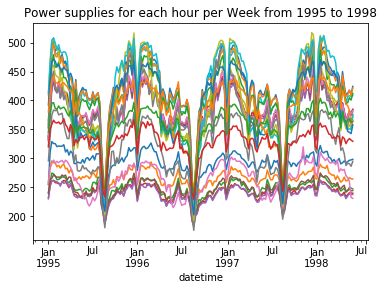

In [42]:
def create_hourly_data(data, hour):
    if(hour < 0 or hour > 23):
        print("Must be between 0 and 24")
        return;
    
    data = list(map(lambda x: (x[0], x[1], int(x[2])), data))
    
    filtered_data = list(filter(lambda x: int(x[2]) == hour, data))
    
    dates = pd.date_range('1995-01-01', periods=len(filtered_data), freq='D')
    
    X = pd.DataFrame(filtered_data)
    
    X.rename(columns={0: 'main_grid',1: 'other_grid', 2: 'hour'}, inplace=True)
    
    X['datetime'] = dates
    X.set_index('datetime', inplace = True)
    
    
    return pd.Series(X['main_grid'] + X['other_grid'])

data, meta = util.read_arf('powersupply.arff');

week_agg = lambda data_: data_.resample('W-Mon').mean()
month_agg = lambda data_: data_.resample('MS').mean()
daily_agg = lambda data_: data_

agg = week_agg

filtered_hours = [0,6,7,18,21,22]

X = [create_hourly_data(data, hour) for hour in range(0, 24)]   

X = [agg(i) for i in X]

[i.plot() for i in X]
plt.title('Power supplies for each hour per Week from 1995 to 1998')
plt.show()

### Test Stationary

Using rolling mean and std dev we will plot if our data is stationary or non-stationary.


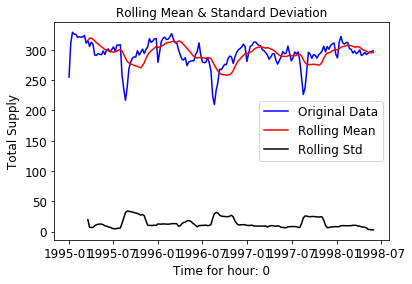

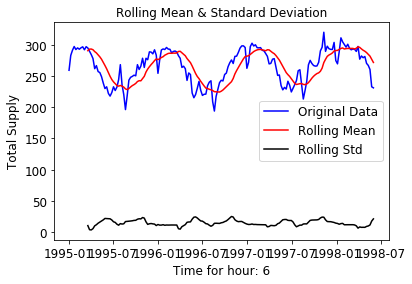

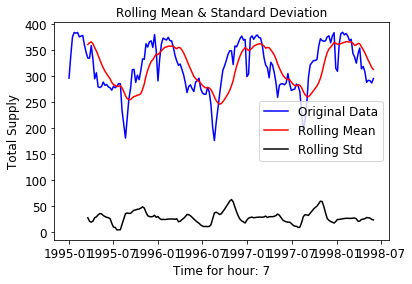

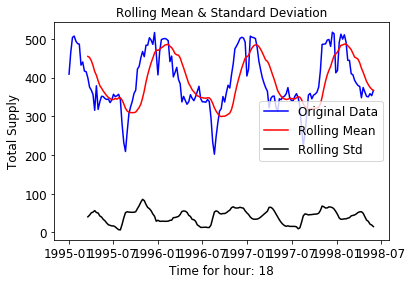

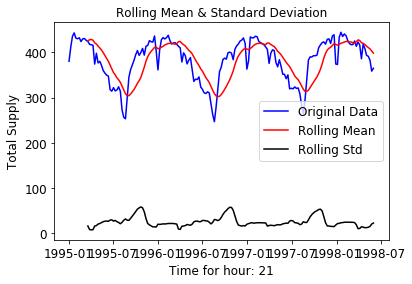

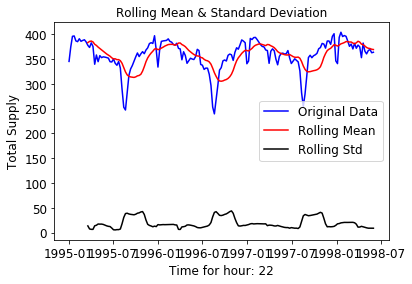

In [43]:
def test_stationary_plot(ts, i):
    fontsize = 12
    figsize = (12,8)
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    
    plt.xlabel('Time for hour: {}'.format(i), fontsize = fontsize)
    plt.ylabel('Total Supply', fontsize = fontsize)
    plt.legend(loc='best', fontsize = fontsize)
    plt.title('Rolling Mean & Standard Deviation', fontsize = fontsize)
    plt.show(block= True)

for index, data in enumerate(X):
    if index in filtered_hours:
        test_stationary_plot(data,index)

From the plot we can see that our data does not have increased trend overtime, hence our data should be stationary.

In order to confirm that we will run Dicker Fuller test to confirm this hypothesis.

Identical values:
0-5
6
7-17
18-20
21
22-23


    hour   p-value  stationary
0      0  0.000011        True
1      1  0.000013        True
2      2  0.000007        True
3      3  0.000269        True
4      4  0.000016        True
5      5  0.003940        True
6      6  0.005489        True
7      7  0.056422       False
8      8  0.012505       False
9      9  0.001960        True
10    10  0.001806        True
11    11  0.001072        True
12    12  0.001103        True
13    13  0.000667        True
14    14  0.000277        True
15    15  0.000226        True
16    16  0.000005        True
17    17  0.001240        True
18    18  0.017405       False
19    19  0.023597       False
20    20  0.011777       False
21    21  0.071955       False
22    22  0.004628        True
23    23  0.000999        True


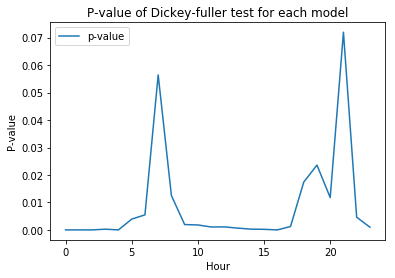

In [45]:
def test_stationary_adfuller(ts,ind, cutoff = 0.01, debug=False):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    
    
    if(debug):
        print(ts_test_output)
        if ts_test[1] <= cutoff:
            print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
        else:
            print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
    
    return {'hour': ind,'p-value': ts_test[1], 'stationary': ts_test[1] <= cutoff};
        
# results in table
result = [test_stationary_adfuller(i,ind) for ind,i in enumerate(X)]

result = pd.DataFrame(result)
print(result)

plt.plot(result['hour'], result['p-value'])
plt.xlabel('Hour')
plt.ylabel('P-value')
plt.legend(loc='best')
plt.title('P-value of Dickey-fuller test for each model')
plt.show();

## Autocorrelation plotting

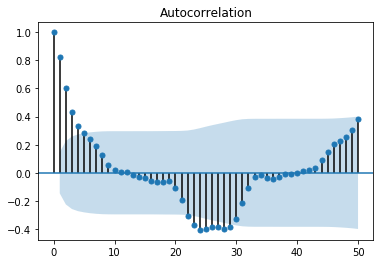

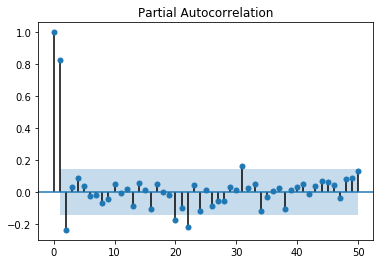

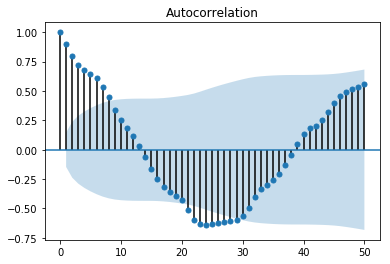

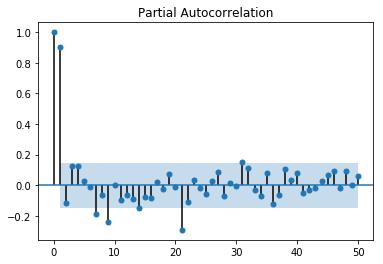

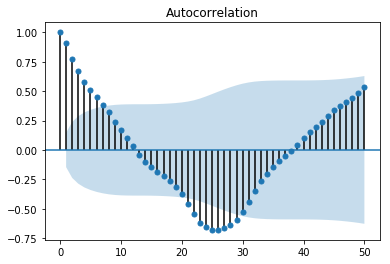

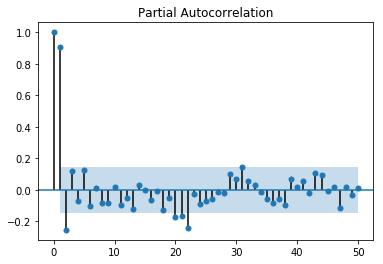

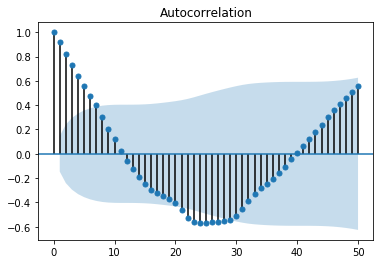

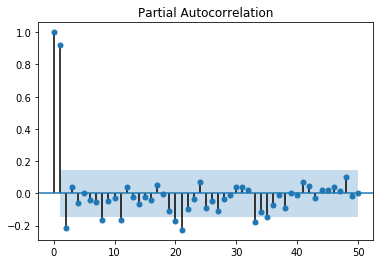

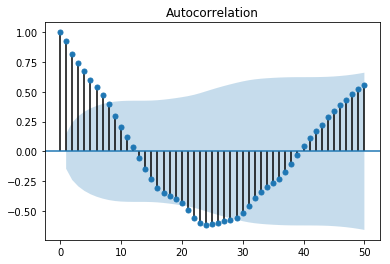

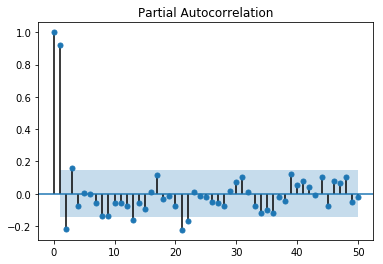

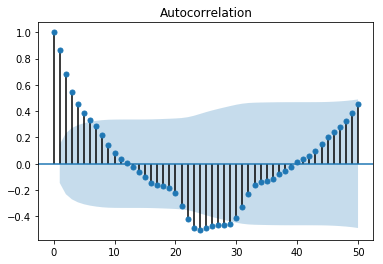

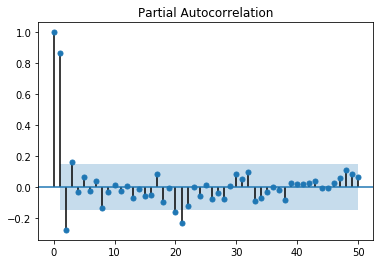

In [46]:
for index, data in enumerate(X):
    if index in filtered_hours:
        statsmodels.graphics.tsaplots.plot_acf(data, lags=50)
        plt.show()
        statsmodels.graphics.tsaplots.plot_pacf(data, lags=50)
        plt.show()
        

Test Statistic                -7.111260e+00
p-value                        3.933601e-10
#Lags Used                     0.000000e+00
Number of Observations Used    1.260000e+02
Critical Value (1%)           -3.483346e+00
Critical Value (5%)           -2.884766e+00
Critical Value (10%)          -2.579156e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


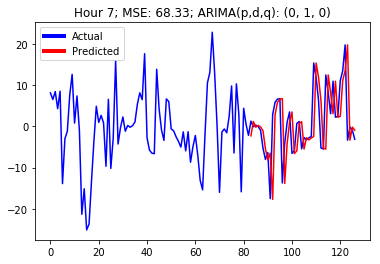

Test Statistic                  -4.757239
p-value                          0.000066
#Lags Used                       8.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


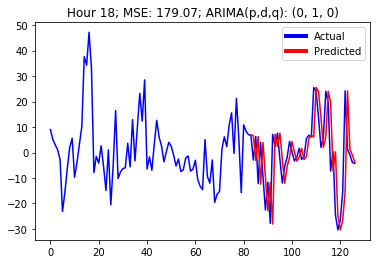

Test Statistic                  -4.158354
p-value                          0.000774
#Lags Used                       4.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


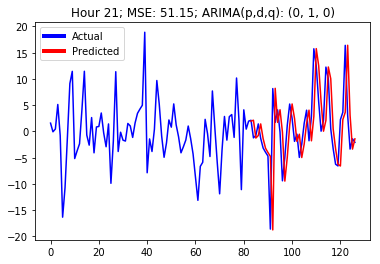

[68.33440285371536, 179.07080855818032, 51.14921550488999]


In [72]:
def apply_arima(data,index, params=(0,1,0), make_plot=True):
    X = data.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()

    step_prediction = 1
    step_size = 1

    num_steps = len(test)

    i = 0
    
    conf_ints = []

    while i < num_steps:

        if(num_steps < i+ step_size):
            break;
            
#         model = sm.tsa.statespace.SARIMAX(history, order=(0,1,1), seasonal_order=(0,1,1,12))
        model = ARIMA(history, order=params)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast(steps = step_size)[0]
    
        conf_ints.append(model_fit.conf_int())
        
        yhat = [output[z] for z in range(step_size)]

        for num in yhat:
            predictions.append(num)

        obs = [test[z] for z in range(i+ step_prediction)]

        for o in obs:
            history.append(o)

        i = i + step_size


    error = mean_squared_error(test, predictions)
    if(make_plot):
        # plot
        legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual'),
                       Line2D([0], [0], color='r',lw=4, label='Predicted')]

        # Create the figure

        plt.plot(X, color='b')
        plt.plot([(i + len(X) - len(predictions)) for i in range(0, len(predictions))], predictions, color='red')
        plt.legend(handles=legend_elements, loc='best')
        plt.title('Hour {0}; MSE: {1:.2f}; ARIMA(p,d,q): {2}'.format(index, error, params))
        plt.show()
        
    return error, conf_ints
    
mse_list = []
params_dict = {
    0:(0,1,1),
    6:(0,1,1),
    7:(1,1,1),
    18:(1,1,1),
    21:(1,1,1)
    
}
for index, data in enumerate(X):
#     if index in filtered_hours:
    if index in [7,18, 21]:
        decomposition = seasonal_decompose(data)
        # check for stationarity
        test_stationary_adfuller(decomposition.resid.dropna(inplace=False), index, debug=True)
        mse, _ = apply_arima(decomposition.resid.dropna(inplace=False),index, params=(0,1,0))
        mse_list.append(mse) 
        
print(mse_list)



## MSE for each time frame

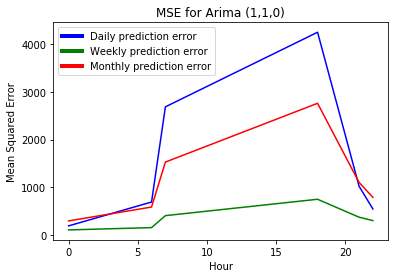

In [48]:
weekly_mse = [105.93057062931072, 153.93269535924762, 405.0105665636236, 748.2856983274663, 372.3732077495627, 301.7221703343384]

month_mse = [294.308931251289, 585.6102621641792, 1527.5834658766446, 2759.08287548221, 1101.1612499555226, 787.4890439993685]
daily_mse = [190.22611133408293, 690.2127780951337, 2684.725558704408, 4248.037330927733, 1020.9577246672759, 544.8940293445996]

hours = [0, 6,7,18,21, 22]



legend_elements = [Line2D([0], [0], color='b', lw=4, label='Daily prediction error'),
                   Line2D([0], [0], color='g',lw=4, label='Weekly prediction error'),
                   Line2D([0], [0], color='r',lw=4, label='Monthly prediction error')]



plt.legend(handles=legend_elements, loc='best')
plt.plot(hours, daily_mse, color='b')
plt.plot(hours, weekly_mse, color='g')
plt.plot(hours, month_mse, color='r')
plt.xlabel('Hour')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Arima (1,1,0)')
plt.show()









In [49]:
def apply_auto_arima(data,index, make_plot=True):
    X = data.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()

    step_prediction = 1
    step_size = 1

    num_steps = len(test)

    i = 0
    
    stepwise_fit = auto_arima(history, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise
    
    print(stepwise_fit.summary())
    
    while i < num_steps:

        if(num_steps < i+ step_size):
            break;
        
        try:
            stepwise_fit = stepwise_fit.fit(history)
        except:
            continue
      
        
        output = stepwise_fit.predict(n_periods=1)
        
        yhat = [output[z] for z in range(step_size)]

        for num in yhat:
            predictions.append(num)

        obs = [test[z] for z in range(i+ step_prediction)]

        for o in obs:
            history.append(o)

        i = i + step_size


    error = mean_squared_error(test, predictions)
    if(make_plot):
        # plot
        legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual'),
                       Line2D([0], [0], color='r',lw=4, label='Predicted')]

        # Create the figure

        plt.plot(X, color='b')
        plt.plot([(i + len(X) - len(predictions)) for i in range(0, len(predictions))], predictions, color='red')
        plt.legend(handles=legend_elements, loc='best')
        plt.title('Hour {0}; MSE: {1:.2f}'.format(index, error))
        plt.show()
        
    return error


mse_list = []
for index, data in enumerate(X):
    if index in filtered_hours:
        # extract trend from the data
        decomposition = seasonal_decompose(data)
        # check for stationarity
        test_stationary_adfuller(decomposition.resid.dropna(inplace=False), index, debug=True)
        test_stationary_adfuller(data, index, debug=True)
#         mse = apply_auto_arima(decomposition.resid.dropna(inplace=False),index)
#         mse_list.append(mse)

Test Statistic                -6.554096e+00
p-value                        8.703630e-09
#Lags Used                     0.000000e+00
Number of Observations Used    1.260000e+02
Critical Value (1%)           -3.483346e+00
Critical Value (5%)           -2.884766e+00
Critical Value (10%)          -2.579156e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary
Test Statistic                  -5.145322
p-value                          0.000011
#Lags Used                       1.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary
Test Statistic                  -3.915601
p-value                          0.001923
#Lags Used                       4.000000
Numb

# Baseline approach

Test MSE: 108.165


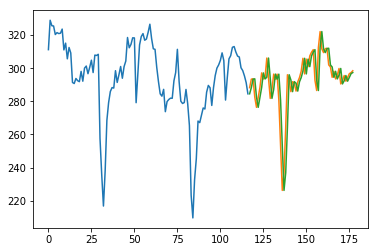

Test MSE: 150.819


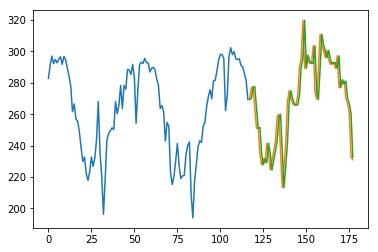

Test MSE: 397.982


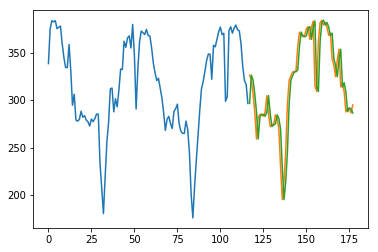

Test MSE: 762.043


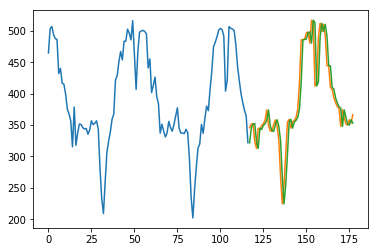

Test MSE: 358.135


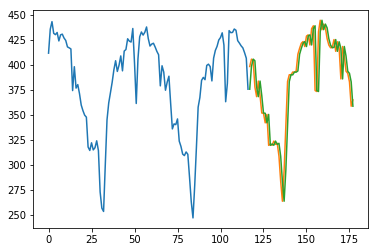

Test MSE: 285.022


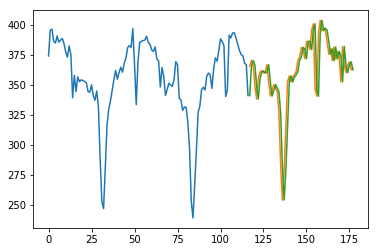

[108.16538093379435, 150.81861157577794, 397.98174389427874, 762.0431385450354, 358.1351882829637, 285.02228504516575]


In [50]:
def pred_baseline(data, index):
    # split into train and test sets
    values = pd.DataFrame(data.values)
    
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']
    X = dataframe.values
    train_size = int(len(X) * 0.66)
    train, test = X[1:train_size], X[train_size:]
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]

    # persistence model
    def model_persistence(x):
        return x

    # walk-forward validation
    predictions = list()
    for x in test_X:
        yhat = model_persistence(x)
        predictions.append(yhat)
    test_score = mean_squared_error(test_y, predictions)
    print('Test MSE: %.3f' % test_score)
    
     
    # plot predictions and expected results
    plt.plot(train_y)
    plt.plot([None for i in train_y] + [x for x in test_y])
    plt.plot([None for i in train_y] + [x for x in predictions])
    plt.show()
    
    return test_score
    
mse_list = []
for index, data in enumerate(X):
    if index in filtered_hours:
        mse_list.append(pred_baseline(data, index))

print(mse_list)

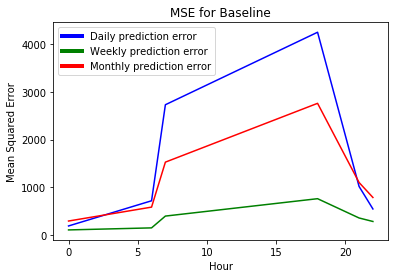

In [41]:
weekly_baseline = [108.16538093379435, 150.81861157577794, 397.98174389427874, 762.0431385450354, 358.1351882829637, 285.02228504516575]
daily_baseline = [191.15957547169816, 718.3524941176471, 2729.5105896226414, 4247.623891509434, 1018.4178773584905, 547.2645518867924]
month_baseline = [307.28747886460917, 576.8991162388331, 1322.7612772107768, 2353.3804534509286, 1060.6281671202564, 726.3294217145716]
hours = [0, 6,7,18,21, 22]



legend_elements = [Line2D([0], [0], color='b', lw=4, label='Daily prediction error'),
                   Line2D([0], [0], color='g',lw=4, label='Weekly prediction error'),
                   Line2D([0], [0], color='r',lw=4, label='Monthly prediction error')]



plt.legend(handles=legend_elements, loc='best')
plt.plot(hours, daily_baseline, color='b')
plt.plot(hours, weekly_baseline, color='g')
plt.plot(hours, month_mse, color='r')
plt.xlabel('Hour')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Baseline')
plt.show()
